C:\Users\natra\AppData\Local\Temp\ipykernel_28240\77983393.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.rename(columns={'temp': 'y'}, inplace=True)
10:38:37 - cmdstanpy - INFO - Chain [1] start processing
10:38:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model Hyperparameters:
Yearly Seasonality: True
Weekly Seasonality: auto
Daily Seasonality: auto
Changepoint Prior Scale: 0.05
Seasonality Prior Scale: 10.0
Seasonality Mode: additive
R² Score: 0.654
RMSE: 3.102
MAE: 2.501


c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


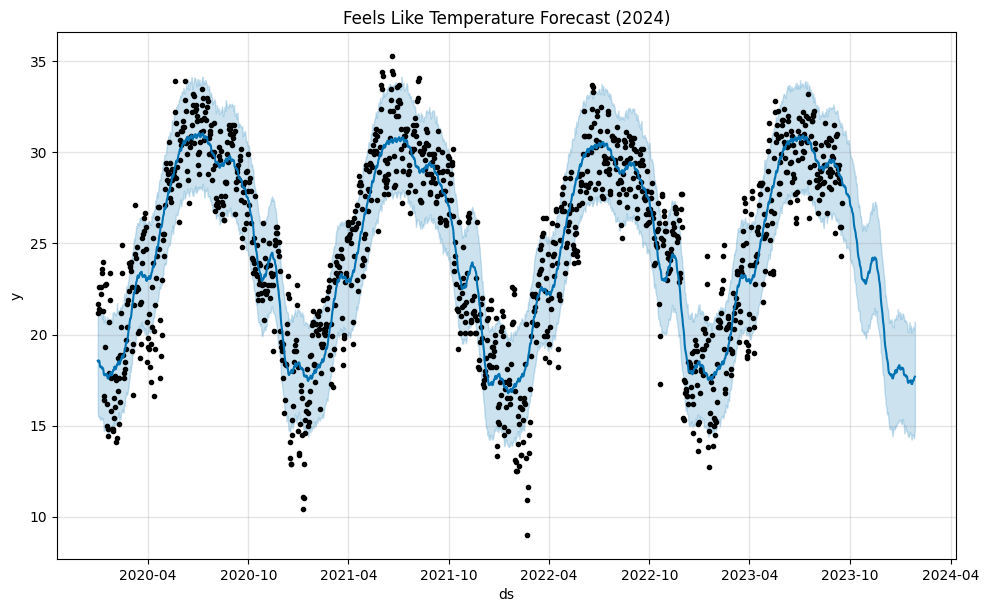

In [2]:
# Required imports
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from prophet import Prophet
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../../../dataset/data.csv'
data = pd.read_csv(file_path)

# Prepare the data for Prophet (for feels like temperature)
data['ds'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
temp_data = data[['ds', 'temp']]  # Rename feels like temperature for Prophet
temp_data.rename(columns={'temp': 'y'}, inplace=True)

# Train-test split (80% training, 20% testing)
train_size = int(0.8 * len(temp_data))
train_data = temp_data[:train_size]  # 80% for training
test_data = temp_data[train_size:]   # 20% for validation

# Initialize and fit the Prophet model for feels like temperature
temp_model = Prophet(yearly_seasonality=True)
temp_model.fit(train_data)

# Print the hyperparameters of the model
print("Model Hyperparameters:")
print(f"Yearly Seasonality: {temp_model.yearly_seasonality}")
print(f"Weekly Seasonality: {temp_model.weekly_seasonality}")
print(f"Daily Seasonality: {temp_model.daily_seasonality}")
print(f"Changepoint Prior Scale: {temp_model.changepoint_prior_scale}")
print(f"Seasonality Prior Scale: {temp_model.seasonality_prior_scale}")
print(f"Seasonality Mode: {temp_model.seasonality_mode}")

# Predict on the test set (validation set)
test_forecast = temp_model.predict(test_data[['ds']])

# Calculate R², RMSE, and MAE
y_true = test_data['y'].values  # Actual feels like temperatures
y_pred = test_forecast['yhat'].values  # Predicted feels like temperatures

# Calculate the R² score
r2 = r2_score(y_true, y_pred)

# Calculate the RMSE
rmse = mean_squared_error(y_true, y_pred, squared=False)

# Calculate the MAE
mae = mean_absolute_error(y_true, y_pred)

# Display the performance metrics
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Generate future dates (from 21/08/2024 to 31/12/2024)
future_dates = temp_model.make_future_dataframe(periods=len(pd.date_range('2024-08-21', '2024-12-31')), freq='D')

# Predict future feels like temperatures
temp_forecast = temp_model.predict(future_dates)

# Display and save the predicted feels like temperatures
temp_forecast[['ds', 'yhat']].tail()
temp_forecast[['ds', 'yhat']].to_csv('temp_forecast_2024.csv', index=False)

# Plot the forecasted feels like temperatures
temp_model.plot(temp_forecast)
plt.title("Feels Like Temperature Forecast (2024)")
plt.show()
